# Predicting Cost Variance of school building projects
Copyright 2024 Fulvio Re Cecconi

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License . You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied . See the License for the specific language governing permissions and limitations under the License.

#Preliminay operations

**Connect to Google Drive and import Libraries**

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import random
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Concatenate, Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
# mount GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Read the raw data**

In [ ]:
# read the data from Google Drive
data = pd.read_csv('/content/drive/MyDrive/2024_NYdata/Capital_Project_Schedules_and_Budgets_20240723.csv') #Change the path
print('Read',len(data),'records')
# show some data
data.head()

Read 14201 records


,Project Geographic District,Project Building Identifier,Project School Name,Project Type,Project Description,Project Phase Name,Project Status Name,Project Phase Actual Start Date,Project Phase Planned End Date,Project Phase Actual End Date,Project Budget Amount,Final Estimate of Actual Costs Through End of Phase Amount,Total Phase Actual Spending Amount,DSF Number(s)
0,1,M015,P.S. 15 - MANHATTAN,SCA CIP,PLANYC BOILER CONVERSION / PLANYC CLIMATE CONTROL,Scope,Complete,6/18/2019,11/19/2019,8/30/2019,76269,108074.0,108074.0,"DSF0000798463, DSF0000912540"
1,1,M015,P.S. 15 - MANHATTAN,SCA CIP,PLANYC BOILER CONVERSION / PLANYC CLIMATE CONTROL,Design,Complete,9/6/2019,2/11/2020,1/30/2020,372960,511537.0,497646.0,"DSF0000798463, DSF0000912540"
2,1,M015,P.S. 15 - MANHATTAN,SCA CIP,PLANYC BOILER CONVERSION / PLANYC CLIMATE CONTROL,Construction,In-Progress,5/3/2021,5/2/2023,NaN,7666299,7194648.0,6647399.0,"DSF0000798463, DSF0000912540"
3,1,M015,P.S. 15 - MANHATTAN,SCA CIP,PLANYC BOILER CONVERSION / PLANYC CLIMATE CONTROL,"CM,F&E",In-Progress,5/3/2021,5/2/2023,NaN,596773,337299.0,329309.0,"DSF0000798463, DSF0000912540"
4,1,M015,M094 SPED - MANHATTAN,SCA Furniture & Equipment,FY23 RESO A MOBILE SCIENCE LAB,F&E,Complete,5/1/2023,NaN,10/4/2023,75000,75000.0,75000.0,DSF0001035619


#Data Cleaning

In [ ]:
# delete unused column
data.__delitem__('Project School Name')
data.__delitem__('DSF Number(s)')
data.__delitem__('Project Building Identifier')

In [ ]:
# convert Project Budget Amount to a number and delete records with errors
print('The dataset contains', len(data), 'records')
data['Project Budget Amount'] = pd.to_numeric(data['Project Budget Amount'], errors='coerce')
data.dropna(subset=['Project Budget Amount'])
# save for data cleaning picture
start_length=len(data)
print('Remaining records after dropping the ones with budget=NaN:', start_length)

The dataset contains 14201 records
Remaining records after dropping the ones with budget=NaN: 14201


In [ ]:
# Use only project with
# Project staus = coomplete
# Project budget > 5000 $
# Final estimate of actual costs through end of phase > 0
# Totale phase actual spending amount > 0
filtered_data = data[(data['Project Status Name'] == 'Complete') &
                     (data['Project Budget Amount'] > 5000) &
                     (data['Final Estimate of Actual Costs Through End of Phase Amount'] > 0) &
                     (data['Total Phase Actual Spending Amount'] > 0)].copy()
# save for data cleaning picture
complete_project_length=len(filtered_data)
print('filtered_data len:', complete_project_length)

# Don't need 'Project Status Name' column anymore
filtered_data.drop(['Project Status Name'], axis=1, inplace=True)

# delete duplicates
new_data = filtered_data.drop_duplicates(subset=['Project Phase Actual Start Date', 'Project Phase Planned End Date',
                                                 'Project Phase Actual End Date', 'Project Phase Name']).copy()

# delete unused data
del data, filtered_data

# prin the numbers of project remaining
# save for data cleaning picture
unique_project_length=len(new_data)
print('unique_project_length:', unique_project_length)

# show some data
new_data.head(5)

filtered_data len: 2708
unique_project_length: 2608


,Project Geographic District,Project Type,Project Description,Project Phase Name,Project Phase Actual Start Date,Project Phase Planned End Date,Project Phase Actual End Date,Project Budget Amount,Final Estimate of Actual Costs Through End of Phase Amount,Total Phase Actual Spending Amount
0,1,SCA CIP,PLANYC BOILER CONVERSION / PLANYC CLIMATE CONTROL,Scope,6/18/2019,11/19/2019,8/30/2019,76269.0,108074.0,108074.0
1,1,SCA CIP,PLANYC BOILER CONVERSION / PLANYC CLIMATE CONTROL,Design,9/6/2019,2/11/2020,1/30/2020,372960.0,511537.0,497646.0
4,1,SCA Furniture & Equipment,FY23 RESO A MOBILE SCIENCE LAB,F&E,5/1/2023,NaN,10/4/2023,75000.0,75000.0,75000.0
9,1,SCA CIP,PLANYC BOILER CONVERSION / PLANYC CLIMATE CONTROL,Scope,4/13/2021,9/13/2021,7/1/2021,68660.0,67746.0,67746.0
10,1,SCA CIP,PLANYC BOILER CONVERSION / PLANYC CLIMATE CONTROL,Design,7/6/2021,12/7/2021,11/29/2021,343300.0,350175.0,282273.0


In [ ]:
# dates conversion
new_data['Project Phase Actual Start Date'] = pd.to_datetime(new_data['Project Phase Actual Start Date'],
                                                             format='%m/%d/%Y')
new_data['Project Phase Planned End Date'] = pd.to_datetime(new_data['Project Phase Planned End Date'],
                                                             format='%m/%d/%Y')
new_data['Project Phase Actual End Date'] = pd.to_datetime(new_data['Project Phase Actual End Date'],
                                                             format='%m/%d/%Y')

# delete rows where conversion failed
new_data.dropna(subset='Project Phase Planned End Date', inplace=True)
new_data.dropna(subset='Project Phase Actual Start Date', inplace=True)
new_data.dropna(subset='Project Phase Actual End Date', inplace=True)

# save for data cleaning picture
dates_length=len(new_data)
print('Number of project remaining:', dates_length)

Number of project remaining: 2585


In [ ]:
# add duration and delays column
new_data['Planned_Duration'] = new_data['Project Phase Planned End Date'] - new_data['Project Phase Actual Start Date']
new_data['Duration'] = new_data['Project Phase Actual End Date'] - new_data['Project Phase Actual Start Date']
new_data['Delay'] = new_data['Project Phase Actual End Date'] - new_data['Project Phase Planned End Date']

# delete rows with planned duration <= 10
new_data=new_data[(new_data['Planned_Duration']/np.timedelta64(1, 'D'))>10]

# delete rows with actual duration <= 10
new_data=new_data[(new_data['Duration']/np.timedelta64(1, 'D'))>10]

# save for data cleaning picture
duration_length=len(new_data)
print('Number of project remaining:', duration_length)

Number of project remaining: 2522


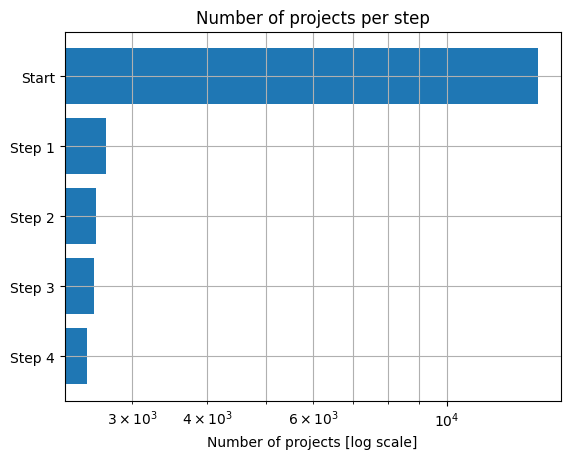

In [ ]:
# plot the data cleaning process
fig = plt.figure(dpi=100)
plt.barh(['Start', 'Step 1', 'Step 2', 'Step 3', 'Step 4'],[start_length, complete_project_length, unique_project_length, dates_length, duration_length])
plt.xscale('log')
plt.xlabel('Number of projects [log scale]')
plt.grid(True, which='both')
plt.title('Number of projects per step')
plt.gca().invert_yaxis()
plt.show()

**Clean the tesx in the project description**

In [ ]:
# remove some strings from the project description
def remove_strings(text, strings):
  """
  This function removes all the strings in the list from the text and returns the cleaned text.

  Args:
      text: The text to be cleaned.
      strings: A list of strings to be removed from the text.

  Returns:
      The cleaned text with all the strings in the list removed.
  """
  for string in strings:
    text = text.replace(string, "")
    text = text.replace("  ", " ")
  return text.strip()

str_to_be_removed=['FY17', 'FY08', 'FY09', 'FY10', 'FY11', 'FY12', 'FY13',
                   'FY 14', 'FY14', 'FY15', 'FY16', 'FY17', 'FY18', 'FY19',
                   'FY20', 'FY21', 'FY22', 'FY23', 'FY24', 'RESO A', 'RESO A-',
                   'DEP/DOE', 'IDA', 'LSP', 'LL26', 'PO18', 'CTF ', '-', '@', 'M488',
                   'M520', 'EME ', 'UPE ', 'RPZ ', 'PLANYC']

# clean the project description column
new_data['Project Description']=new_data['Project Description'].apply(lambda x: remove_strings(x, str_to_be_removed))

#Exploratory data analysis

In [ ]:
# Calculate the overbudget for each project by subtracting the
# 'Project Budget Amount' from the 'Total Phase Actual Spending Amount'.
new_data['Overbudget'] = new_data['Total Phase Actual Spending Amount'] - new_data['Project Budget Amount']
# statistical description of the dataset
new_data.describe()

,Project Geographic District,Project Phase Actual Start Date,Project Phase Planned End Date,Project Phase Actual End Date,Project Budget Amount,Final Estimate of Actual Costs Through End of Phase Amount,Total Phase Actual Spending Amount,Planned_Duration,Duration,Delay,Overbudget
count,2522.000000,2522,2522,2522,2.522000e+03,2.522000e+03,2.522000e+03,2522,2522,2522,2.522000e+03
mean,17.481364,2021-02-04 10:25:47.343378432,2021-08-11 14:05:02.616970752,2021-10-27 07:17:22.030135040,5.058959e+05,4.383086e+05,3.851670e+05,188 days 03:39:15.273592386,264 days 20:51:34.686756544,76 days 17:12:19.413164155,-1.207290e+05
min,1.000000,2011-09-26 00:00:00,2012-01-12 00:00:00,2011-12-06 00:00:00,5.100000e+03,1.600000e+01,6.000000e+00,14 days 00:00:00,11 days 00:00:00,-240 days +00:00:00,-1.371546e+07
25%,9.000000,2019-09-28 00:00:00,2020-05-04 06:00:00,2020-08-22 12:00:00,3.298050e+04,4.344450e+04,3.407800e+04,137 days 00:00:00,114 days 00:00:00,-40 days +06:00:00,-6.436375e+04
50%,18.000000,2021-07-26 00:00:00,2022-01-19 00:00:00,2022-04-22 00:00:00,1.019990e+05,1.228655e+05,1.057060e+05,153 days 00:00:00,173 days 00:00:00,7 days 00:00:00,-5.642000e+03
75%,26.000000,2022-08-26 00:00:00,2023-03-06 18:00:00,2023-04-27 00:00:00,3.374755e+05,3.208980e+05,2.817318e+05,179 days 18:00:00,288 days 00:00:00,101 days 18:00:00,1.914225e+04
max,32.000000,2024-02-21 00:00:00,2024-07-23 00:00:00,2024-03-29 00:00:00,7.861805e+07,7.218289e+07,6.490259e+07,2498 days 00:00:00,2400 days 00:00:00,2184 days 00:00:00,2.092811e+06
std,9.440845,NaN,NaN,NaN,2.548267e+06,2.335781e+06,2.117776e+06,160 days 11:35:01.691921094,292 days 13:48:04.539999544,227 days 18:22:04.514170984,6.059153e+05


Scope  -  1096
Design  -  1293
Construction  -  66
CM,F&E  -  66
CM,Art,F&E  -  1


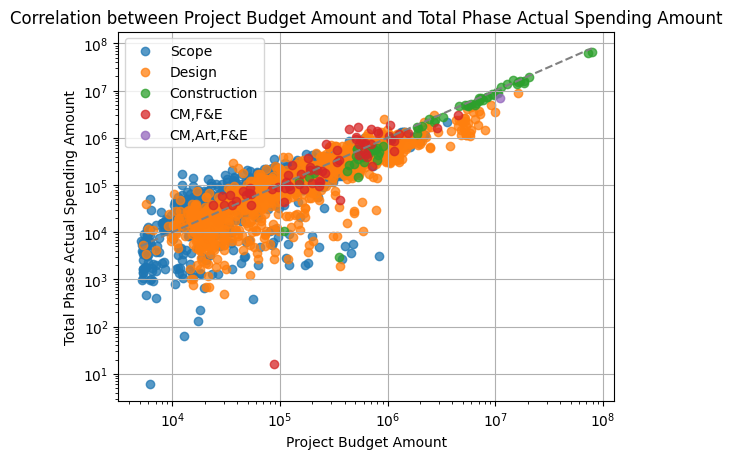

In [ ]:
# Correlation between 'Project Budget Amount' and 'Total Phase Actual Spending Amount'
# Highlight Project Phase Name
for pt in new_data['Project Phase Name'].unique():
  print(pt,' - ',len(new_data[new_data['Project Phase Name'] == pt]))
# draw the correlation between budget and actual costs
fig = plt.figure(dpi=100)
for pt in new_data['Project Phase Name'].unique():
  plt_data = new_data[new_data['Project Phase Name'] == pt]
  plt.scatter(plt_data['Project Budget Amount'],
              plt_data['Total Phase Actual Spending Amount'],
              alpha=0.75, label=pt)
plt.plot([np.min(new_data['Project Budget Amount']),np.max(new_data['Project Budget Amount'])],
 [np.min(new_data['Project Budget Amount']),np.max(new_data['Project Budget Amount'])],
         '--',color='Gray')
plt.legend()
plt.xlabel('Project Budget Amount')
plt.ylabel('Total Phase Actual Spending Amount')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.title('Correlation between Project Budget Amount and Total Phase Actual Spending Amount')
plt.show()

SCA CIP  -  2129
SCA CIP RESOA  -  267
3K  -  28
SCA Lease Site Improvement  -  19
SCA Capacity  -  79


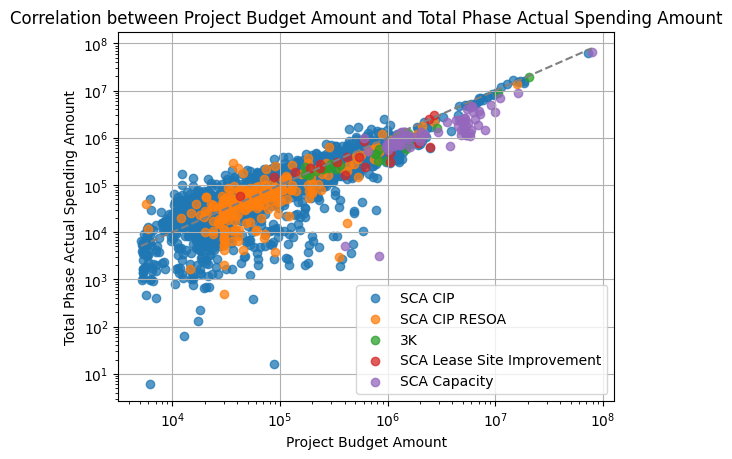

In [ ]:
# Correlation between 'Project Budget Amount' and 'Total Phase Actual Spending Amount'
# Highlight Project type
for pt in new_data['Project Type '].unique():
  print(pt,' - ',len(new_data[new_data['Project Type '] == pt]))
# draw the correlation between budget and actual costs
fig = plt.figure(dpi=100)
for pt in new_data['Project Type '].unique():
  plt_data = new_data[new_data['Project Type '] == pt]
  plt.scatter(plt_data['Project Budget Amount'],
              plt_data['Total Phase Actual Spending Amount'],
              alpha=0.75, label=pt)
plt.plot([np.min(new_data['Project Budget Amount']),np.max(new_data['Project Budget Amount'])],
 [np.min(new_data['Project Budget Amount']),np.max(new_data['Project Budget Amount'])],
         '--',color='Gray')
plt.legend()
plt.xlabel('Project Budget Amount')
plt.ylabel('Total Phase Actual Spending Amount')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.title('Correlation between Project Budget Amount and Total Phase Actual Spending Amount')
plt.show()

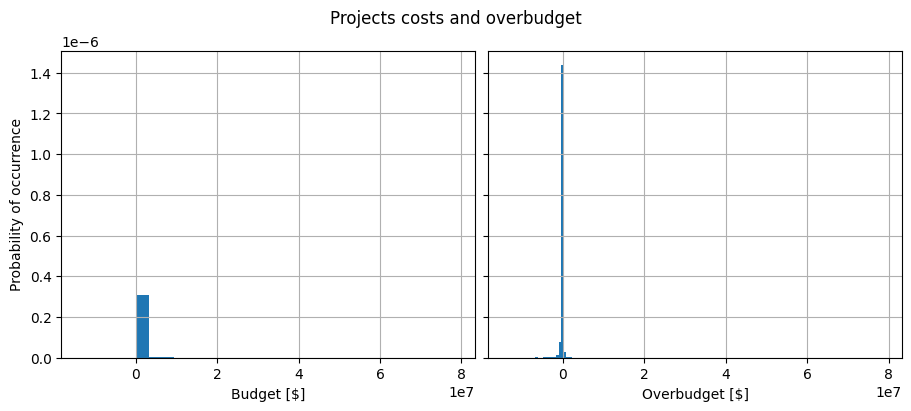

In [ ]:
# Plot budget and overbudget

# Create a figure with a specified size and layout.
fig = plt.figure(figsize=(9, 4), layout="constrained")

# Create two subplots that share the same x and y axes.
axs = fig.subplots(1, 2, sharex=True, sharey=True)

# Set the number of bins for the histograms.
n_bins = 25

# Create a histogram of the 'Project Budget Amount' on the first subplot.
# The histogram is normalized, uses stepfilled style, and is not cumulative.
n, bins, patches = axs[0].hist(new_data['Project Budget Amount'], n_bins,
                               density=True, histtype='stepfilled',
                               cumulative=False, label='Budget')

# Create a histogram of the 'Overbudget' on the second subplot,
n, bins, patches = axs[1].hist(new_data['Overbudget'], n_bins,
                               density=True, histtype='stepfilled',
                               cumulative=False, label='Overbudget')

# Set titles, labels, and display the plot.
fig.suptitle('Projects costs and overbudget')
axs[0].set_xlabel('Budget [$]')
axs[0].set_ylabel('Probability of occurrence')
axs[0].grid(True)
axs[1].set_xlabel('Overbudget [$]')
axs[1].grid(True)
plt.show()

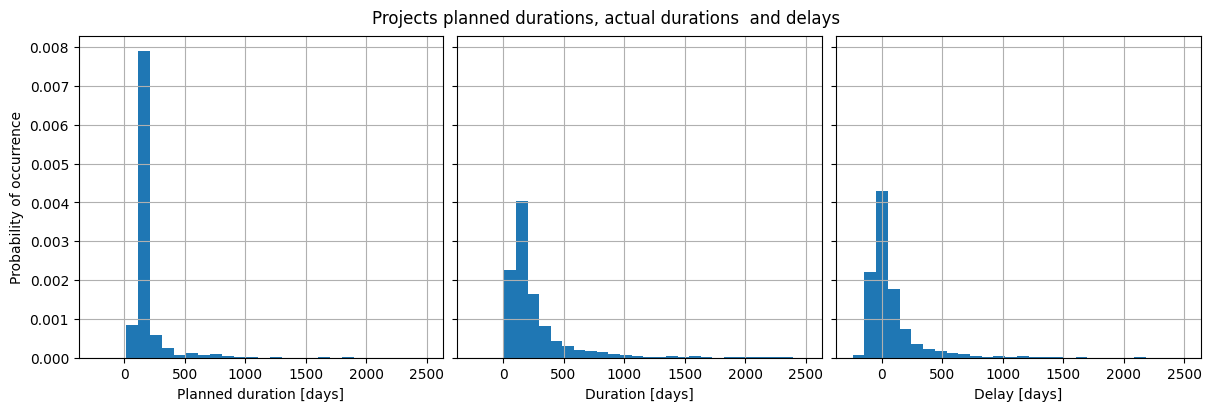

In [ ]:
# plot duration and delay histograms
fig = plt.figure(figsize=(12, 4), layout="constrained")
axs = fig.subplots(1, 3, sharex=True, sharey=True)
n_bins = 25
n, bins, patches = axs[0].hist(new_data['Planned_Duration']/np.timedelta64(1, 'D'), n_bins, density=True, histtype='stepfilled',
                               cumulative=False, label='Duration')
n, bins, patches = axs[1].hist(new_data['Duration']/np.timedelta64(1, 'D'), n_bins, density=True, histtype='stepfilled',
                               cumulative=False, label='Duration')
n, bins, patches = axs[2].hist(new_data['Delay']/np.timedelta64(1, 'D'), n_bins, density=True, histtype='stepfilled',
                               cumulative=False, label='Delay')
fig.suptitle('Projects planned durations, actual durations  and delays')
axs[0].set_xlabel('Planned duration [days]')
axs[0].grid(True)
axs[0].set_ylabel('Probability of occurrence')
axs[1].set_xlabel('Duration [days]')
axs[1].grid(True)
axs[2].set_xlabel('Delay [days]')
axs[2].grid(True)
plt.show()

In [ ]:
# Delete unused conlumns and create e new dataset
short_data=new_data.drop(['Project Phase Actual End Date', 'Project Phase Actual Start Date',
                          'Project Phase Actual End Date', 'Project Phase Planned End Date',
                          'Total Phase Actual Spending Amount', 'Final Estimate of Actual Costs Through End of Phase Amount'], axis=1, inplace=False)

# remove projects with budget > 10Ml
short_data=short_data[short_data['Project Budget Amount']<=10000000]

# remove project with planned duration >= 2000 days or <= 10 days
short_data=short_data[((short_data['Planned_Duration']/np.timedelta64(1, 'D'))<2000)&((short_data['Planned_Duration']/np.timedelta64(1, 'D'))>10)]

# remove project with Delay >= 2000 days
short_data=short_data[short_data['Delay']<2000*np.timedelta64(1, 'D')]

# remove projects with overbudget <-1 Ml
# short_data=short_data[short_data['Overbudget']>= -1000000]

# add duration and delays column
# add two columns: relative overbudget and relative delay
short_data['Relative_overbudget']=short_data['Overbudget']/short_data['Project Budget Amount']
short_data['Relative_delay']=short_data['Delay']/short_data['Planned_Duration']

# delet outlyers
short_data=short_data[short_data['Relative_delay']<=10]
short_data=short_data[short_data['Relative_overbudget']<=6]
print('Starting with:', len(new_data),' projects - ending with:', len(short_data), ' projects')
short_data.describe()

Starting with: 2522  projects - ending with: 2492  projects


,Project Geographic District,Project Budget Amount,Planned_Duration,Duration,Delay,Overbudget,Relative_overbudget,Relative_delay
count,2492.000000,2.492000e+03,2492,2492,2492,2.492000e+03,2492.000000,2492.000000
mean,17.484751,3.680662e+05,182 days 12:53:44.398073836,252 days 01:23:12.616372392,69 days 12:29:28.218298555,-1.008849e+05,0.058507,0.442403
std,9.442858,9.188435e+05,133 days 19:29:01.251701226,256 days 03:46:45.538794056,204 days 17:54:40.402441210,4.504028e+05,0.749414,1.251887
min,1.000000,5.100000e+03,18 days 00:00:00,11 days 00:00:00,-240 days +00:00:00,-6.603170e+06,-0.999818,-0.915254
25%,9.000000,3.286650e+04,137 days 00:00:00,113 days 00:00:00,-40 days +00:00:00,-6.240025e+04,-0.402370,-0.235399
50%,18.000000,1.001930e+05,153 days 00:00:00,170 days 00:00:00,7 days 00:00:00,-5.568500e+03,-0.083488,0.040817
75%,26.000000,3.261688e+05,179 days 00:00:00,281 days 06:00:00,99 days 00:00:00,1.901550e+04,0.322496,0.636360
max,32.000000,9.967950e+06,1824 days 00:00:00,2289 days 00:00:00,1660 days 00:00:00,1.560385e+06,5.817403,9.975610


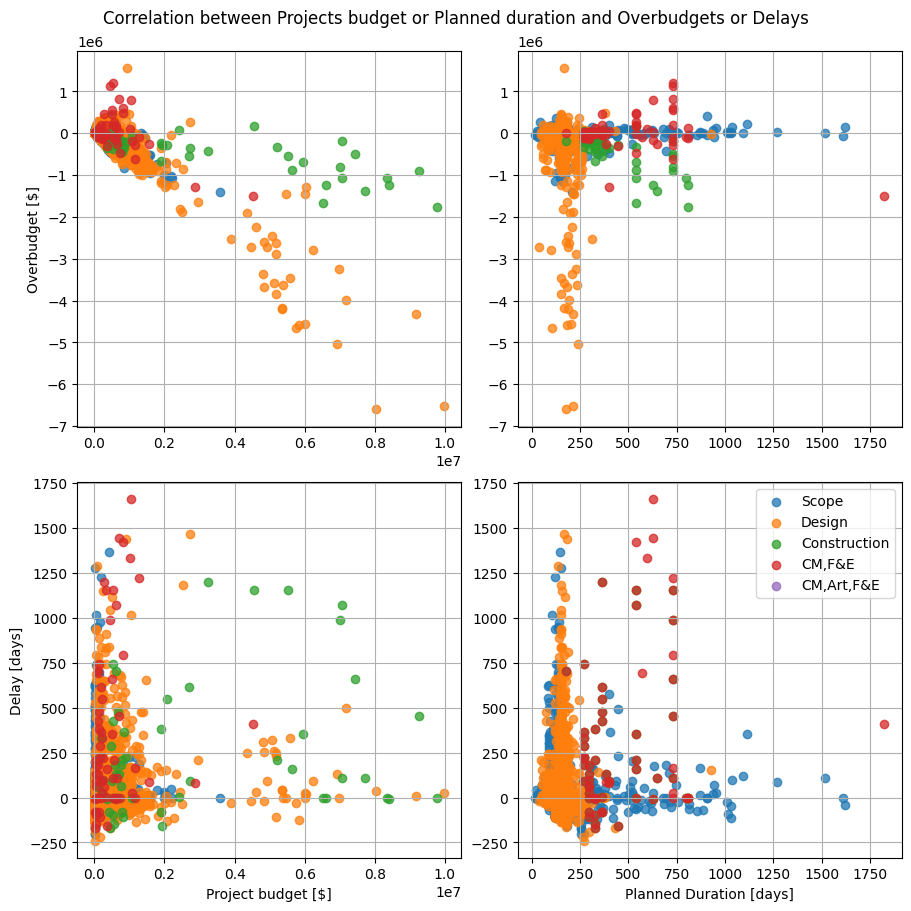

In [ ]:
# plot the correlation between budget, duration, overbadget and delays as a function of the project type
fig = plt.figure(figsize=(9, 9), layout="constrained", dpi=100)
axs = fig.subplots(2, 2, sharex=False, sharey=False)
for pt in new_data['Project Phase Name'].unique():
  plt_data = short_data[short_data['Project Phase Name'] == pt]
  axs[0,0].scatter(plt_data['Project Budget Amount'],plt_data['Overbudget'], alpha=0.75, label=pt)
  axs[0,1].scatter(plt_data['Planned_Duration']/np.timedelta64(1, 'D'),plt_data['Overbudget'], alpha=0.75, label=pt)
  axs[1,0].scatter(plt_data['Project Budget Amount'],plt_data['Delay']/np.timedelta64(1, 'D'), alpha=0.75, label=pt)
  axs[1,1].scatter(plt_data['Planned_Duration']/np.timedelta64(1, 'D'),plt_data['Delay']/np.timedelta64(1, 'D'), alpha=0.75, label=pt)
fig.suptitle('Correlation between Projects budget or Planned duration and Overbudgets or Delays')
axs[1,0].set_xlabel('Project budget [$]')
axs[1,1].set_xlabel('Planned Duration [days]')
axs[0,0].set_ylabel('Overbudget [$]')
axs[1,0].set_ylabel('Delay [days]')
axs[0,0].grid(True)
axs[0,1].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)
lgnd_left=axs[1,1].legend()
plt.show()

In [ ]:
# Split the dataset in
# faster and cheaper
fac=short_data[(short_data['Relative_delay']<0) & (short_data['Relative_overbudget']<0)]
print('total number of records', len(short_data))
print('Faster and cheaper:', len(fac))
# slower and more expensive
sme=short_data[(short_data['Relative_overbudget']>=0) & (short_data['Relative_delay']>=0)]
print('Slower and more expensive:', len(sme))
# faster or cheaper
foc=short_data.drop(fac.index, inplace=False).drop(sme.index, inplace=False)
print('Faster of cheaper:', len(foc))

total number of records 2492
Faster and cheaper: 654
Slower and more expensive: 658
Faster of cheaper: 1180


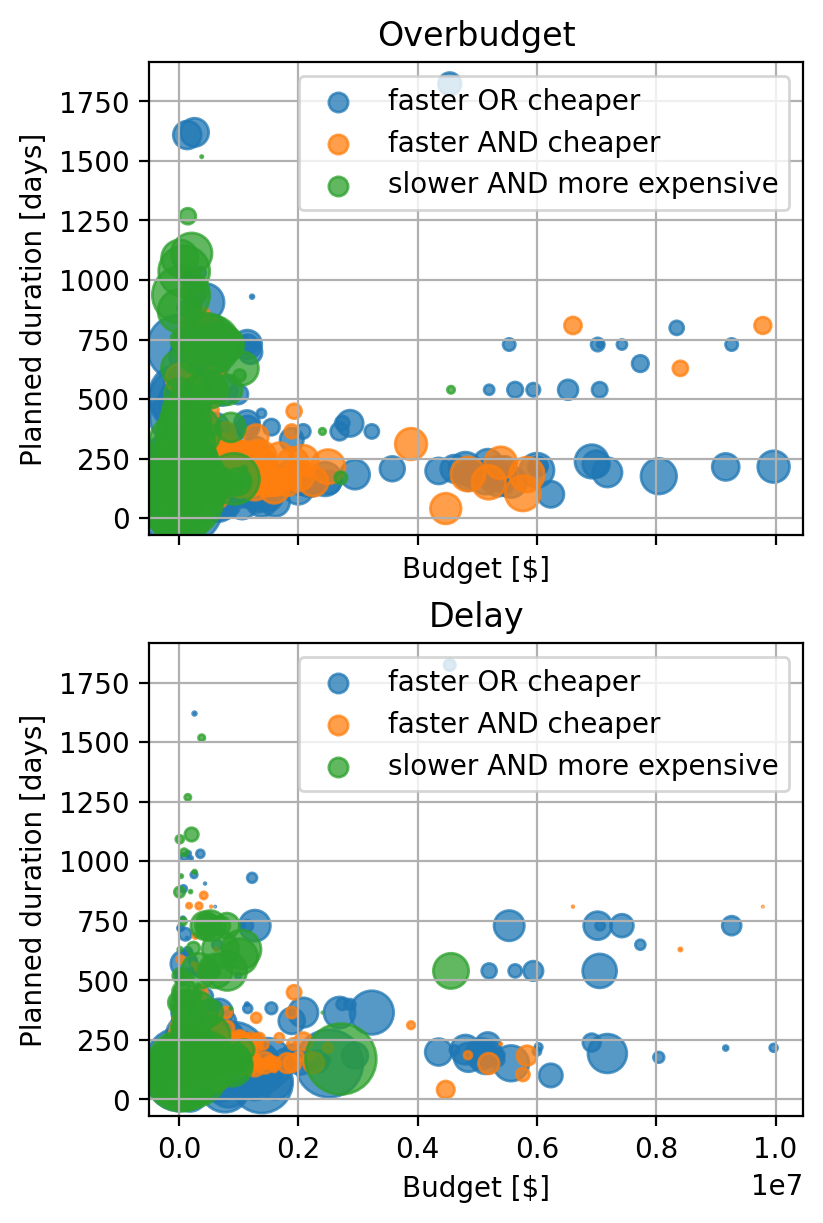

In [ ]:
# plot the correlation between budget and planned duration
# highlighting the overbudgets and the delays
# scale budget
budget_scale=200
# scale delay
delay_scale=75
fig = plt.figure(figsize=(4, 6), layout="constrained", dpi=200)
axs = fig.subplots(2, 1, sharex=True, sharey=True)
n_bins = 25
#faster or cheaper
axs[0].scatter(foc['Project Budget Amount'],
               foc['Planned_Duration']/np.timedelta64(1, 'D'),
               s= np.abs(foc['Relative_overbudget'])*budget_scale,alpha=0.75, label='faster OR cheaper')
# faster and cheaper
axs[0].scatter(fac['Project Budget Amount'],
               fac['Planned_Duration']/np.timedelta64(1, 'D'),
               s= fac['Relative_overbudget']*-budget_scale,alpha=0.75, label='faster AND cheaper')
#slower and more expensive
axs[0].scatter(sme['Project Budget Amount'],
               sme['Planned_Duration']/np.timedelta64(1, 'D'),
               s= sme['Relative_overbudget']*budget_scale,alpha=0.75, label='slower AND more expensive')
#faster or cheaper
axs[1].scatter(foc['Project Budget Amount'],
               foc['Planned_Duration']/np.timedelta64(1, 'D'),
               s= np.abs(foc['Relative_delay']*delay_scale),alpha=0.75, label='faster OR cheaper')
# faster and cheaper
axs[1].scatter(fac['Project Budget Amount'],
               fac['Planned_Duration']/np.timedelta64(1, 'D'),
               s= fac['Relative_delay']*-delay_scale,alpha=0.75, label='faster AND cheaper')
#slower and more expensive
axs[1].scatter(sme['Project Budget Amount'],
               sme['Planned_Duration']/np.timedelta64(1, 'D'),
               s= sme['Relative_delay']*delay_scale,alpha=0.75, label='slower AND more expensive')

axs[0].set_title('Overbudget')
axs[0].set_xlabel('Budget [$]')
axs[0].set_ylabel('Planned duration [days]')
lgnd_left=axs[0].legend()
for handle in lgnd_left.legend_handles:
    handle.set_sizes([48.0])
axs[0].grid(True)
axs[1].set_xlabel('Budget [$]')
axs[1].set_ylabel('Planned duration [days]')
axs[1].set_title('Delay')
lgnd_right=axs[1].legend()
for handle in lgnd_right.legend_handles:
    handle.set_sizes([48.0])
axs[1].grid(True)
plt.show()

# Prepare input for the ANN
**Transform categorical data into numbers (encoding) and use transformes to encode the project description**

In [ ]:
# use pandas get_dummies to one-hot encode the project type and the project phase
short_data=pd.get_dummies(short_data,columns=['Project Type ', 'Project Phase Name'])
# drop also relative delay and relative overbudget (not to be used anymore)
short_data.drop(['Relative_delay', 'Relative_overbudget'], axis=1, inplace=False)
short_data.head()

,Project Geographic District,Project Description,Project Budget Amount,Planned_Duration,Duration,Delay,Overbudget,Relative_overbudget,Relative_delay,Project Type _3K,Project Type _SCA CIP,Project Type _SCA CIP RESOA,Project Type _SCA Capacity,Project Type _SCA Lease Site Improvement,"Project Phase Name_CM,F&E",Project Phase Name_Construction,Project Phase Name_Design,Project Phase Name_Scope
0,1,BOILER CONVERSION / CLIMATE CONTROL,76269.0,154 days,73 days,-81 days,31805.0,0.417011,-0.525974,False,True,False,False,False,False,False,False,True
1,1,BOILER CONVERSION / CLIMATE CONTROL,372960.0,158 days,146 days,-12 days,124686.0,0.334315,-0.075949,False,True,False,False,False,False,False,True,False
9,1,BOILER CONVERSION / CLIMATE CONTROL,68660.0,153 days,79 days,-74 days,-914.0,-0.013312,-0.483660,False,True,False,False,False,False,False,False,True
10,1,BOILER CONVERSION / CLIMATE CONTROL,343300.0,154 days,146 days,-8 days,-61027.0,-0.177766,-0.051948,False,True,False,False,False,False,False,True,False
13,1,IPDVS CAMERA INSTALLATION,5388.0,123 days,14 days,-109 days,-3978.0,-0.738307,-0.886179,False,True,False,False,False,False,False,False,True


In [ ]:
#replace duration and delays with numbers
def day_to_num(day):
      return day/np.timedelta64(1, 'D')
# apply the function to the column
short_data.loc[:,'Planned_Duration'] = short_data['Planned_Duration'].apply(day_to_num)
short_data.loc[:,'Duration'] = short_data['Duration'].apply(day_to_num)
short_data.loc[:,'Delay'] = short_data['Delay'].apply(day_to_num)
short_data.head()

,Project Geographic District,Project Description,Project Budget Amount,Planned_Duration,Duration,Delay,Overbudget,Relative_overbudget,Relative_delay,Project Type _3K,Project Type _SCA CIP,Project Type _SCA CIP RESOA,Project Type _SCA Capacity,Project Type _SCA Lease Site Improvement,"Project Phase Name_CM,F&E",Project Phase Name_Construction,Project Phase Name_Design,Project Phase Name_Scope
0,1,BOILER CONVERSION / CLIMATE CONTROL,76269.0,154.0,73.0,-81.0,31805.0,0.417011,-0.525974,False,True,False,False,False,False,False,False,True
1,1,BOILER CONVERSION / CLIMATE CONTROL,372960.0,158.0,146.0,-12.0,124686.0,0.334315,-0.075949,False,True,False,False,False,False,False,True,False
9,1,BOILER CONVERSION / CLIMATE CONTROL,68660.0,153.0,79.0,-74.0,-914.0,-0.013312,-0.483660,False,True,False,False,False,False,False,False,True
10,1,BOILER CONVERSION / CLIMATE CONTROL,343300.0,154.0,146.0,-8.0,-61027.0,-0.177766,-0.051948,False,True,False,False,False,False,False,True,False
13,1,IPDVS CAMERA INSTALLATION,5388.0,123.0,14.0,-109.0,-3978.0,-0.738307,-0.886179,False,True,False,False,False,False,False,False,True


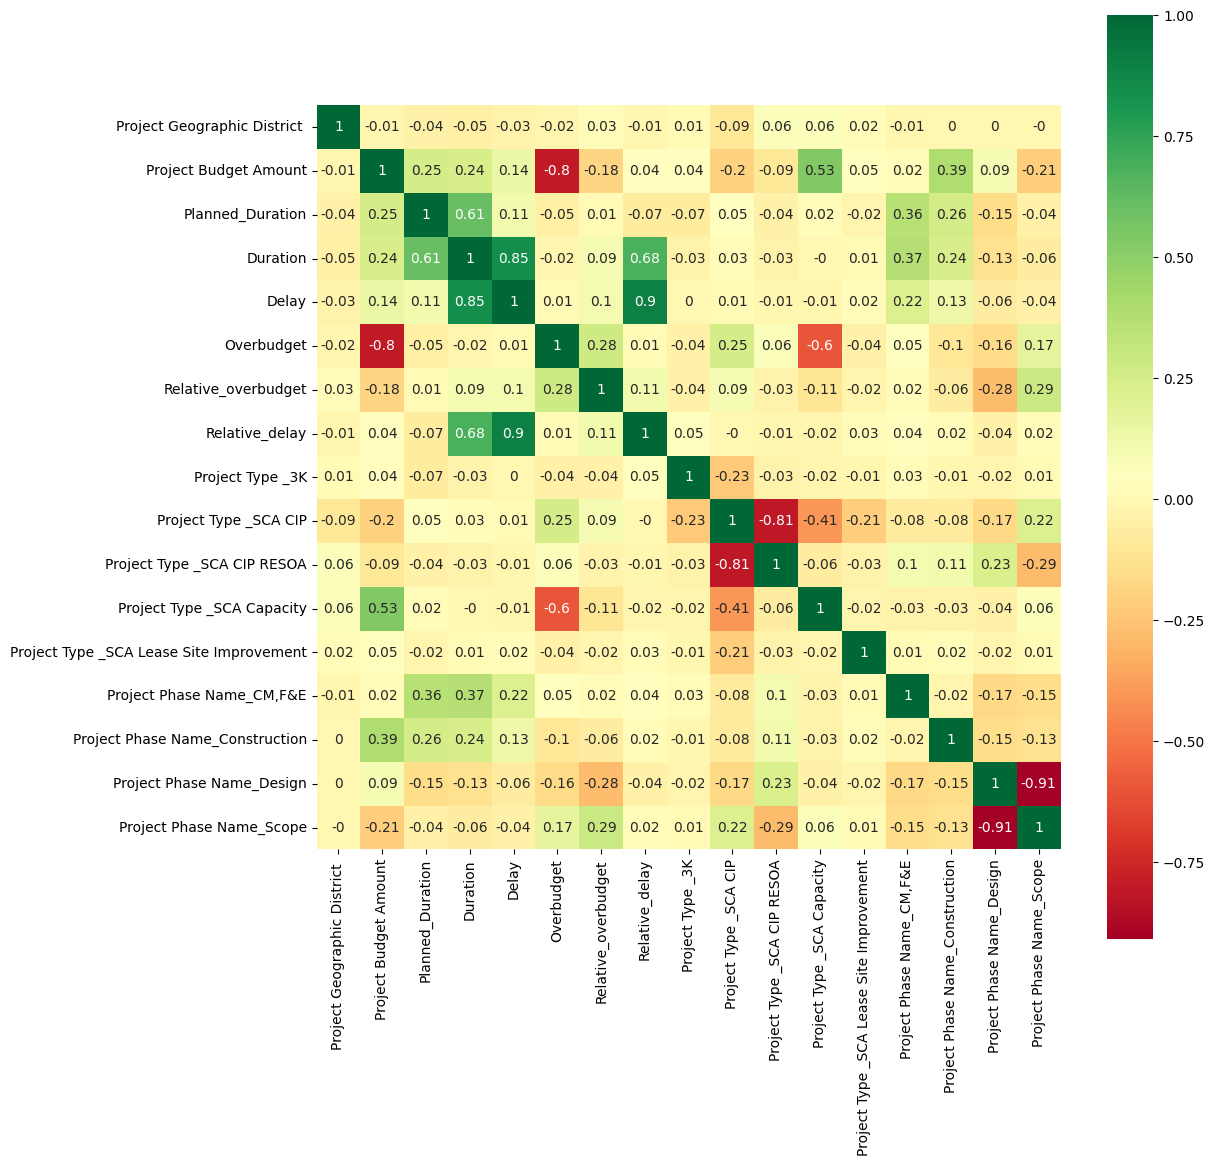

In [ ]:
# plot of the correlation matrix
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
sns.heatmap(short_data.drop('Project Description',axis=1, inplace=False).corr().round(2),
            square=True, cmap='RdYlGn', annot=True)
plt.show()

In [ ]:
# prepare  the dataset using only meaningfull columns
X = short_data[['Project Geographic District ', 'Project Description',
       'Project Budget Amount', 'Planned_Duration',
       'Project Type _3K', 'Project Type _SCA CIP',
       'Project Type _SCA CIP RESOA', 'Project Type _SCA Capacity',
       'Project Type _SCA Lease Site Improvement', 'Project Phase Name_CM,F&E',
       'Project Phase Name_Construction', 'Project Phase Name_Design',
       'Project Phase Name_Scope']].copy()
Y = short_data['Overbudget']

In [ ]:
# Create train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# prepare input for the model
explore_dataset = pd.concat([X_train, Y_train], axis=1, sort=False)
train_dataset = explore_dataset.sample(frac=0.8, random_state=42)
train_feature = train_dataset.drop('Overbudget', axis=1)
train_label = train_dataset['Overbudget']
valid_dataset = explore_dataset.drop(train_dataset.index)
valid_feature = valid_dataset.drop('Overbudget', axis=1)
valid_label = valid_dataset[ 'Overbudget']
explore_dataset.head()

,Project Geographic District,Project Description,Project Budget Amount,Planned_Duration,Project Type _3K,Project Type _SCA CIP,Project Type _SCA CIP RESOA,Project Type _SCA Capacity,Project Type _SCA Lease Site Improvement,"Project Phase Name_CM,F&E",Project Phase Name_Construction,Project Phase Name_Design,Project Phase Name_Scope,Overbudget
1725,4,IPDVS CAMERA INSTALLATION,18045.0,181.0,False,True,False,False,False,False,False,True,False,-16418.0
3381,9,FULL PROGRAM ACCESSIBILITY / FIRE ALARM / PARA...,150499.0,1268.0,False,True,False,False,False,False,False,False,True,24962.0
7083,19,IPDVS INSTALLATIONS,19776.0,180.0,False,True,False,False,False,False,False,True,False,-1845.0
11314,27,PLAYGROUND REDEVELOPMENT,39330.0,136.0,False,True,False,False,False,False,False,True,False,7179.0
2438,7,EXTERIOR MASONRY / PARAPETS / ROOFS,285806.0,154.0,False,True,False,False,False,False,False,True,False,-52769.0


**Compute embeddings**

In [ ]:
# install transformers library
!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 5.3 MB/s eta 0:00:00


In [ ]:
# import library
from sentence_transformers import SentenceTransformer

# define the model to be used
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# transform project description into numeric vectors for train features
train_embeddings = [model.encode(x, convert_to_tensor=True) for x in train_feature['Project Description']]

# remove the Project Description column and convert the dataset into float
train_feature.drop('Project Description', axis=1, inplace=True)
train_feature = train_feature.astype(float)

# transform project description into numeric vectors for validation feature
valid_embeddings = [model.encode(x, convert_to_tensor=True) for x in valid_feature['Project Description']]

# remove the Project Description column and convert the dataset into float
valid_feature.drop('Project Description', axis=1, inplace=True)
valid_feature = valid_feature.astype(float)

# create embeddings for the test data
# transform project description into numeric vectors for train features
test_embeddings = [model.encode(x, convert_to_tensor=True) for x in X_test['Project Description']]

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# remove the Project Description column and convert the dataset into float
X_test.drop('Project Description', axis=1, inplace=True)
X_test = X_test.astype(float)

#Create the Artificial Neural Network

In [ ]:
# function to define the ANN model
def create_and_compile_model(df: pd.DataFrame, embeddings: list):
    # Step 1: Define Input Layer for DataFrame
    float_cols = df.select_dtypes(include=['float'])
    input_shape_df = (len(float_cols.columns),)
    df_input = Input(shape=input_shape_df, name="dataframe_input")

    # Step 2: Apply Keras Normalization Layer to DataFrame Input
    normalization_layer = Normalization()
    normalization_layer.adapt(float_cols.values)
    normalized_df_input = normalization_layer(df_input)

    # Step 3: Define Input Layer for Embeddings
    embedding_dim = embeddings[0].shape[0] # Get the embedding dimension from the first embedding
    embedding_input = Input(shape=(embedding_dim,), name="embedding_input")

    # Step 4: Merge Both Inputs
    merged = Concatenate()([normalized_df_input, embedding_input])

    # Step 5: Add Hidden Layers with ReLU Activation
    hidden = Dense(1024, activation='relu')(merged)
    hidden = Dense(512, activation='relu')(hidden)
    hidden = Dense(256, activation='relu')(hidden)
    hidden = Dense(128, activation='relu')(hidden)
    hidden = Dense(64, activation='relu')(hidden)
    hidden = Dense(32, activation='relu')(hidden)
    hidden = Dense(16, activation='relu')(hidden)

    # Step 6: Add Output Layer
    output = Dense(1, activation='linear', name="output")(hidden)

    # Step 7: Create and Compile the Model
    model = Model(inputs=[df_input, embedding_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

In [ ]:
# create and compile the ANN
ann_model = create_and_compile_model(train_feature, train_embeddings)

# print a summary of the model
ann_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ dataframe_input           │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 12)             │             25 │ dataframe_input[0][0]  │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_input           │ (None, 768)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 780)            │              0 │ normalization_2[0][0], │
│ (Concatenate)             │                        │                │ embedding_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 1024)           │        799,744 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_16 (Dense)          │ (None, 512)            │        524,800 │ dense_15[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 256)            │        131,328 │ dense_16[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 128)            │         32,896 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 64)             │          8,256 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 32)             │          2,080 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 16)             │            528 │ dense_20[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │             17 │ dense_21[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,499,674 (5.72 MB)

 Trainable params: 1,499,649 (5.72 MB)

 Non-trainable params: 25 (104.00 B)

In [ ]:
# Train the model
# Move tensors to CPU and convert to NumPy arrays
train_embeddings_cpu = [t.cpu().numpy() for t in train_embeddings] # Move tensors to CPU and convert to NumPy
# Train the model using the training data and embeddings
history = ann_model.fit([train_feature, np.array(train_embeddings_cpu)], train_label,
          # Validate the model using the validation data and embeddings
          validation_data=([valid_feature, np.array([t.cpu().numpy() for t in valid_embeddings])], valid_label),
          verbose=1, epochs=300, batch_size = 64,
          callbacks=[keras.callbacks.EarlyStopping(patience=50)])

Epoch 1/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - loss: 230721175552.0000 - mae: 140364.1562 - val_loss: 183203348480.0000 - val_mae: 145950.5000
Epoch 2/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 255090655232.0000 - mae: 154003.5625 - val_loss: 169905766400.0000 - val_mae: 142997.9375
Epoch 3/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 223669714944.0000 - mae: 158441.5625 - val_loss: 117276631040.0000 - val_mae: 168482.1250
Epoch 4/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 141086687232.0000 - mae: 159817.3906 - val_loss: 82572361728.0000 - val_mae: 132464.2812
Epoch 5/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 83381764096.0000 - mae: 120764.8281 - val_loss: 64076070912.0000 - val_mae: 115592.2500
Epoch 6/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 68208689152.0000 - mae: 105381.9609 - val_loss: 53766836224.0000 - val_mae: 98643.1875
Epoch 7/300
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54034964480.0000 - mae: 95265.7734 - val_loss: 4304

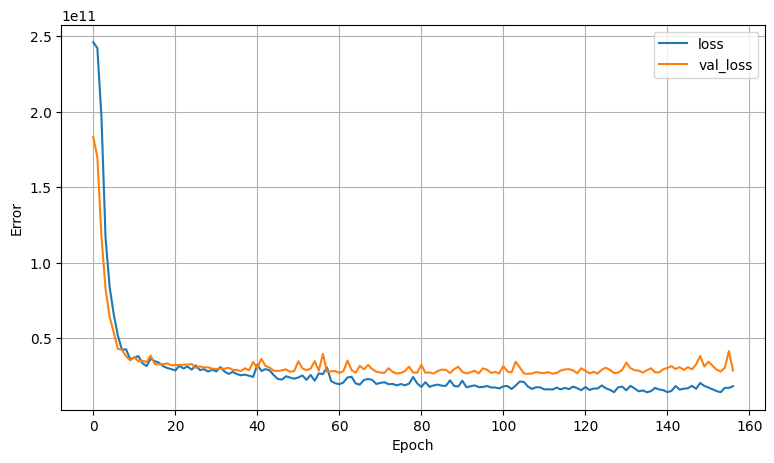

In [ ]:
# Draw loss during training
fig_dpi = 100
fig_size = 5
ra = 1.816
fig = plt.figure(dpi=fig_dpi, figsize=(fig_size * ra, fig_size))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

**Evaluate the model**

In [ ]:
# Compute loss and accuracy for validation and test dataset
# validation dataset
valid_embeddings_cpu = [t.cpu().numpy() for t in valid_embeddings] # Move tensors to CPU and convert to NumPy
loss, accuracy = ann_model.evaluate([valid_feature, np.array(valid_embeddings_cpu)], valid_label)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)
# test datast (data previously unseen by the model)
test_embeddings_cpu = [t.cpu().numpy() for t in test_embeddings] # Move tensors to CPU and convert to NumPy
loss, accuracy = ann_model.evaluate([X_test, np.array(test_embeddings_cpu)], Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29787418624.0000 - mae: 93319.1406   
Validation Loss: 28664911872.0
Validation Accuracy: 86380.171875
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 25514067968.0000 - mae: 88616.1172
Test Loss: 24802435072.0
Test Accuracy: 88287.7890625


In [ ]:
# compute predictions for the validation dataset
valid_embeddings_array = np.array([t.cpu().numpy() for t in valid_embeddings])
valid_predictions = ann_model.predict([valid_feature, valid_embeddings_array])
# compute predictions for the test dataset
test_embeddings_array = np.array([t.cpu().numpy() for t in test_embeddings])
test_predictions = ann_model.predict([X_test, test_embeddings_array])

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


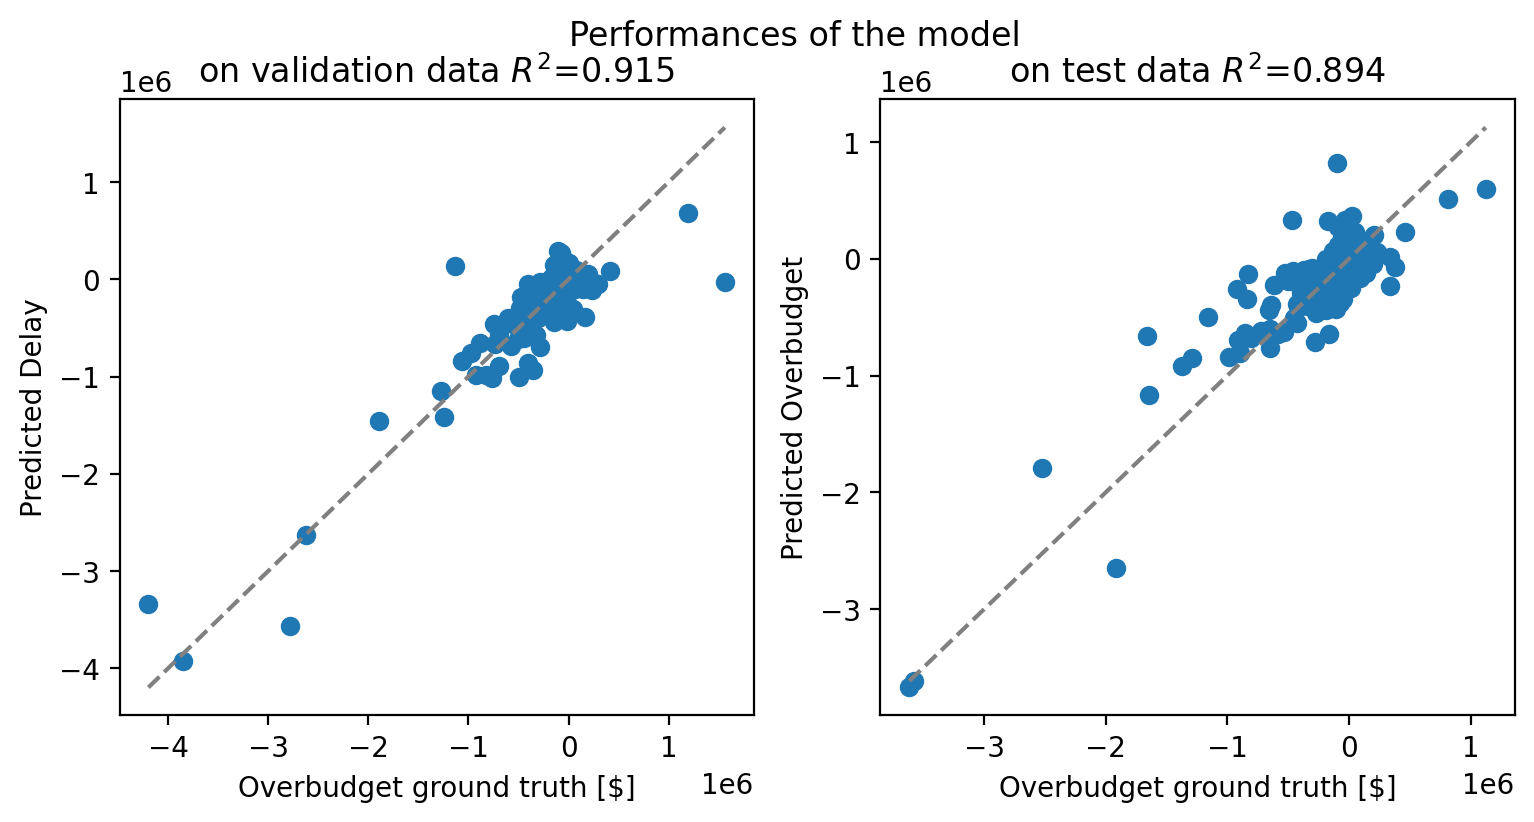

In [ ]:
# plot a comparison between predicted and ground truth for the validation and
# test datasets
fig = plt.figure(figsize=(9, 4), dpi=200)
axs = fig.subplots(1, 2, sharex=False, sharey=False)
axs[0].scatter(valid_label.values, valid_predictions)
axs[0].plot([np.min(valid_label.values),np.max(valid_label.values)],
            [np.min(valid_label.values),np.max(valid_label.values)],
            '--',color='Gray')
axs[0].set_xlabel('Overbudget ground truth [$]')
axs[0].set_ylabel('Predicted Delay')
axs[0].set_title('on validation data $R^2$='+str(np.round(np.corrcoef(valid_label.values, valid_predictions.squeeze())[0,1],3)))
axs[1].scatter(Y_test.values, test_predictions)
axs[1].plot([np.min(Y_test),np.max(Y_test)],
            [np.min(Y_test),np.max(Y_test)],
            '--',color='Gray')
axs[1].set_xlabel('Overbudget ground truth [$]')
axs[1].set_ylabel('Predicted Overbudget')
axs[1].set_title('on test data $R^2$='+str(np.round(np.corrcoef(Y_test.values, test_predictions.squeeze())[0,1],3)))
fig.suptitle('Performances of the model')
plt.show()